## Inicjalizacja środowiska programistycznego

In [ ]:
#Color printing
from termcolor import colored

#General data operations library
import math, string, glob
from datetime import datetime
import numpy as np
import functools

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow  as tf
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import logging
tf.get_logger().setLevel(logging.ERROR)

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params) 

import os
os.chdir("/scratch_hdd/akalinow/Zajecia/2023-2024/Lato/Uczenie_maszynowe_2/UczenieMaszynoweII/PL/")

#append path with python modules
import importlib
import sys
sys.path.append("../modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

#Hide GPU
#tf.config.set_visible_devices([], 'GPU')

<br/><br/>
<br/><br/>

<h1 align="center">
 Uczenie maszynowe II
</h1>

<br/><br/>
<br/><br/>
<br/><br/>
<br/><br/>

<h1 align="right">
Artur Kalinowski <br>
Uniwersytet Warszawski <br>
Wydział Fizyki <br>    
</h1>

## Rowery Kraków

**Zagadnienie:** przewidzieć liczbę rowerzystów na wybranej ulicy Krakowa na podstawie zliczeń z `window_size-1` poprzednich dni.

**Proszę:**

* pobrać dane używając komórki poniżej
* wypisać na ekran podsumowanie danych 

In [ ]:
import pandas as pd

file_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vTWNYLoE3k3JegSt47hV66v5j7_Vh8jIdLRUhcMLrIAW4VcIZK-3W9rGoDSfnToUnCIb9DPngGAlgL6/pub?gid=0&single=true&output=csv'
df = pd.read_csv(file_url)

df = pd.read_csv(file_url, sep=",",parse_dates=[0])
df = df.rename(columns={' ' : "Data"})
df = df.fillna(0)
#BEGIN_SOLUTION
print(df.describe())
#END_SOLUTION
pass

**Proszę:**

* zidentyfikowac dwie ulice o największym średnim natężeniu ruchu
* zachować nazwy tych ulic w zmiennych `train_street` i `val_street`

In [ ]:
#BEGIN_SOLUTION
train_street = "Mogilska"
val_street = "Kotlarska"
#END_SOLUTION
pass

**Proszę:**

* dla obu ulic, na oddzielnych panelach, narysować zliczenia rowerzystów w funkcji daty

In [ ]:
#BEGIN_SOLUTION
fig, axes = plt.subplots(1,2, figsize=(15,4))

axes[0].plot(df["Data"], df[train_street], 'o', label=train_street);
axes[1].plot(df["Data"], df[val_street], 'go', label=val_street);
axes[0].legend()
axes[1].legend()
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15)
#END_SOLUTION
pass


**Proszę:**

* przygotować zbiory `train_dataset` i `val_dataset` zawierające dane z odpowiednich ulic
* znormalizować zliczenia czynnikiem `1/10_1000`
* przetworzyć zbiory do postaci ciągów zliczeń z `window_size` dni.
* ustawić kształt wierszy w danych na `(window_size, 1)`
* podzielić wiersze na `etykiety`: zliczenia z ostatniego dnia i `cechy`: zliczenia z wcześniejszych `window_size-1` dni
* podzielić zbiór na paczki o rozmiarze `16` i zachować go w pamięci podręcznej
* wypisać na ekran cztery przykłady ze zbioru treningowego

**Wskazówka:**
* macierz danych z kolumny zbioru pandas można wyłuskać jako `df.values`
* macierze importujemy do `tf.data.Dataset` używając metody `from_tensor_slices(...)`

In [ ]:
window_size = 11
scale = 10_000
inputDim = 1

train_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[train_street].values/scale))
#BEGIN_SOLUTION
slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size)
train_dataset = train_dataset.map(lambda x: tf.reshape(x, (window_size, inputDim))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()  

val_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[val_street].values/scale))
val_dataset = val_dataset.map(lambda x: tf.reshape(x, (window_size, inputDim))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()

for item in train_dataset.take(4):
    print(colored("Features:","blue"), item[0].numpy()[0,:,0]*scale, end=" ")
    print(colored("Labels:","blue"), item[1].numpy()[0]*scale)
#END_SOLUTION
pass

**Proszę:**

* zbudować model z warstwami LSTM:
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca sekwencję
    * warstwa LSTM, `8` neuronów, zwracająca tylko ostatni element sekwencji
    * warstwa gęsta, `1` neuron
* wypisać na ekran podsumowanie modelu    

In [ ]:
#BEGIN_SOLUTION
model = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, inputDim)),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8, return_sequences=True),
    tf.keras.layers.LSTM(8),
    tf.keras.layers.Dense(1, activation='sigmoid')],
                         name="traffic_prediction")  
model.summary()
#END_SOLUTION
pass

**Proszę:**

* przeprowadzić trening modelu przez `150` epok Trening powinien zawierać standardowe elementy:
    * harmonogram zmiany współczynnika uczenia
    * wywołanie wczesnego zatrzymania 
    * rysowane historii funkcji straty
* kod trenowania zawrzeć w funkcji `trainModel(model, train_dataset, val_dataset)`


In [ ]:
%%time

def trainModel(model, train_dataset, val_dataset):
#BEGIN_SOLUTION
    initial_learning_rate = 1E-3
    nStepsPerEpoch = train_dataset.cardinality().numpy()
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*100,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                  loss='mse', metrics=[])

    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1)
    callbacks = [early_stop_callback]              

    history = model.fit(train_dataset, 
                        validation_data=val_dataset,
                        callbacks=callbacks,
                        epochs=150, verbose=0)
    model.evaluate(train_dataset)
    model.evaluate(val_dataset)
    plf.plotTrainHistory(history)
    return model
#END_SOLUTION

model = trainModel(model, train_dataset, val_dataset)


**Proszę:**

Napisać funkcję `plotPrediction(model, df, streets, train_dataset, val_dataset, scale, window_size)`, która wykonuje rysunki kontrolne w dwue wierszach (ulice) i trzech kolumnach:

* liczby zliczeń rzeczywistą i prognozowaną
* iloraz `rzeczywista/prognozowana`
* histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`
* histogram`(rzeczywista-prognozowana)/rzeczywista` dla modelu prognozowania naiwnego: `jutro będzie tak jak dziś`

**Wskazówka:**
* zakresy dat można na wykresie można kontrolować w następujący sposób:
```Python
axes[index,0].set_xlim([datetime.date(2023, 3, 30), datetime.date(2023, 5, 3)]) 
axes[index,0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
axes[index,0].xaxis.set_minor_locator(mdates.MonthLocator())
```
* do uzyskania modelu naiwnego można użyć `np.roll()`


In [ ]:
def plotPrediction(model, df, streets, train_dataset, val_dataset, scale, window_size):

    fig, axes = plt.subplots(2,3, figsize=(17,6))
    import datetime
    import matplotlib.dates as mdates

    #BEGIN_SOLUTION
    for index,street in enumerate(streets):
        date = df["Data"][window_size-1:]
        y = df[street][window_size-1:].values
        dataset = train_dataset
        if index==1:
            dataset = val_dataset
        y_pred = model.predict(dataset)[:,0]*scale
        y_pred_naive = np.roll(y,1)
        ##
        axes[index,1].set_title(street)
        ##
        axes[index,0].plot(date, y, 'o', label="true");
        axes[index,0].plot(date, y_pred, 'go', label="model");
        axes[index,0].legend()
        #axes[index,0].set_xlim([datetime.date(2019, 12, 1), datetime.date(2021, 1, 31)])
        axes[index,0].set_xlim([datetime.date(2023, 3, 30), datetime.date(2023, 5, 3)]) 
        axes[index,0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
        axes[index,0].xaxis.set_minor_locator(mdates.MonthLocator())
        ##
        axes[index,1].plot(date, y/y_pred, 'o', label="true");
        axes[index,1].plot([date.min(), date.max()], [1,1], 'r')
        axes[index,1].set_xlim([datetime.date(2019, 12, 1), datetime.date(2021, 1, 31)])
        axes[index,1].set_ylim([-2,4])
        axes[index,1].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 6)))
        axes[index,1].xaxis.set_minor_locator(mdates.MonthLocator())
        axes[index,1].set_ylabel("True/Model")
        ##
        counts, _, _ = axes[index,2].hist((y-y_pred)/y, bins=np.linspace(-2,2,50), label="RNN")
        axes[index,2].hist((y-y_pred_naive)/y, bins=np.linspace(-2,2,50), label="Naive", alpha=0.7)
        axes[index,2].set_xlabel(r"$\frac{True-Model}{True}$")
        pull = np.divide((y-y_pred).astype(float), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        #draw text on plot
        axes[index,2].text(0.5, 0.9*counts.max(), r"RNN: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        pull = np.divide((y-y_pred_naive), y, out=np.zeros_like(y, dtype=float), where=y>0)
        mean = np.mean(pull)
        std = np.std(pull)
        axes[index,2].text(0.5, 0.8*counts.max(), r"Naive: $\mu: {:3.2f}, \sigma: {:3.2f}$".format(mean, std))
        ##
        if "Suma opadu dzień  [mm]" in df.columns:
            ax2 = axes[index,0].twinx()
            ax2.plot(date, df["Suma opadu dzień  [mm]"][window_size-1:], 'or', label="opady");  
            ax2.tick_params(axis='y', labelcolor="r")
        if index>1:
            break
    ##
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.25, hspace=0.4)
    #END_SOLUTION

plotPrediction(model, 
               df, [train_street, val_street], 
               train_dataset, val_dataset,
               scale, window_size=window_size)

Model RNN działa nie wiele lepiej niż model naiwny. W szczególności model nie przewiduje poprawnie nagłych spadków zliczeń - prawdopodobnie wywołanych przez złe warunki pogodowe.
Dodajmy dane o pogodzie z danego dnia jako substytut prognozy pogody.

Źródłem danych meteorologicznych jest Instytut Meteorologii i Gospodarki Wodnej – Państwowy Instytut Badawczy”.
Dane o warunkach pogodowych pobierzemy z portalu [IMGW](https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/).
Skorzystamy ze stacji Kraków-Balice.

In [ ]:
#! pip3 install wget
import wget, subprocess
for year in range(2016, 2024):
    url = f"https://danepubliczne.imgw.pl/data/dane_pomiarowo_obserwacyjne/dane_meteorologiczne/dobowe/synop/{year}/{year}_566_s.zip"
    #wget.download(url)
    subprocess.run(["unzip","-o",f"{year}_566_s.zip"])
    #subprocess.run(["mv", "./*.csv", " ../data/Pogoda/"])
    subprocess.run(["rm", "-f", "*.zip"])

Dane załadujemy do obiektu Pandas dataframe.

In [1]:
import pandas as pd

def makeDataFrame(filePath):
    columns = ["Data","zachmurzenie", 
               "prędkość wiatru [m/s]", "temperatura [°C]",
               "ciśnienie pary wodnej [hPa]", "wilgotność względna [%]",             
                "ciśnienie na poziomie stacji [hPa]", "ciśnienie na poziomie morza [hPa]",      
                "Suma opadu dzień  [mm]","Suma opadu noc   [mm]"]    
#BEGIN_SOLUTION
    df = pd.read_csv(filePath,header=None,
                     sep=",", usecols = np.arange(2, 22),
                     parse_dates=[[2,3,4]], 
                     encoding='Latin1').dropna(axis=1)
    df.columns = columns
#END_SOLUTION    
    return df

#BEGIN_SOLUTION
files = glob.glob("../data/Pogoda/s_d_t*.csv")
df_pogoda = pd.concat([makeDataFrame(file) for file in files])
#END_SOLUTION
df_pogoda.describe()

NameError: name 'glob' is not defined

Połączymy obiekty dataframe z danymi o zliczeniach i pogodzie. Dla obu zbiorów ustawiamy datę jako indeks - dzięki temu zapewnimy synchronizację wiersze między oboma zbiorami.

In [ ]:
#BEGIN_SOLUTION
#set date as a index
df.index = df["Data"]
df_pogoda.index = df_pogoda["Data"]

#drop index columns from weather df to avoid duplication
df_pogoda.drop(columns=["Data"], inplace=True)

#merge two dataframes. Only common dates are kept
df_merged = df.join(df_pogoda, how="inner")
#END_SOLUTION
df_merged.describe()

**Proszę:**

Napisać funkcję `prepareDataset(df, street, window_size=11, scale=10_000)` która przygotowuje obiekt `tf.data.Dataset` z danymi i zliczeniach i pogodzie:

* wczytuje dane z macierzy numpy uzyskanej z pandas DataFrame do `tf.data.Dataset`
* dzieli dane na okna o długości `window_size`
* dzieli wiersz danych na krotkę `((sekwencja zliczeń dla 11 dni, dane pogodowe dla danego dnia), zliczenia dla danego dnia)`

**Wskazówki:**

* jako dane wejściowe mozna podać 
```Python
columns = [street, "Suma opadu dzień  [mm]", "temperatura [°C]", "prędkość wiatru [m/s]"]
```

* wszystkie dane wejściowe można podzielić na sekwencje o długości `window_size`, a potem z tej sekwencji wydzielić
  odpowiednie fragmenty. To o oznacza, że teraz sekwencja ma `inputDim = len(columns)` i trzeba z niej wydzielić dane
  o zliczeniach dla odpowiednich dni, etykietę i dane pogodowe

  Oczekiwany efekt dla paczki o rozmiarze 1:
  ```Python
  Features: (<tf.Tensor: shape=(1, 10, 1), dtype=float64, numpy=
  array([[[0.0907],
        [0.0438],
        [0.0549],
        [0.1501],
        [0.1626],
        [0.1555],
        [0.127 ],
        [0.0906],
        [0.0385],
        [0.0246]]])>, <tf.Tensor: shape=(1, 3), dtype=float64, numpy=array([[ 0.3, -0.7,  5.8]])>) Labels: [0.0804]
  ```

In [ ]:
def prepareDataset(df, street, window_size=11, trafficScale=10_000):
    #BEGIN_SOLUTION
    columns = [street, "Suma opadu dzień  [mm]", "temperatura [°C]", "prędkość wiatru [m/s]"]
    sequenceDim = 1

    slidingWindowWithWidth = functools.partial(tf_text.sliding_window, width=window_size, axis=0)

    def features_label_split(dataRow):
        return (tf.reshape(dataRow[:-1,0]/trafficScale, (window_size-1, sequenceDim)), dataRow[-1,1:]), dataRow[-1,0]/trafficScale

    dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df[columns].values))
    dataset = dataset.map(features_label_split).batch(16).cache()
    #END_SOLUTION
    return dataset

window_size = 11
train_dataset = prepareDataset(df_merged, train_street, window_size=window_size)
val_dataset = prepareDataset(df_merged, val_street, window_size=window_size)
item = next(iter(train_dataset))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

**Proszę:**

* wywołać funkcję `prepareDataset(...)` z takimi parametrami by można było łatwo sprawdzić czy dane pogodowe są dobrze zsynchronizowane,
  tzn. dane o pogodzie pochodzą z dnia dla którego model ma przewidzieć zliczenia

* porównać wartości dla pierwszego przykładu w obiekcie `pandas.DataFrame` z odpowiednim przykładem z  `tf.data.Dataset` i sprawdzić czy ten ostatni jest dobrze zsynchronizowany

In [ ]:
#BEGIN_SOLUTION
window_size = 2
x = prepareDataset(df_merged, train_street, trafficScale=1, window_size=window_size)
item = next(iter(x))
print(colored("Features:","blue"), item[0])
print(colored("Labels:","blue"), item[1].numpy())

#Print first 5 rows of the dataset to check if the TF and Pandas dataframes are aligned
df_merged[["Suma opadu dzień  [mm]", "temperatura [°C]", "prędkość wiatru [m/s]", train_street]].head()
#END_SOLUTION

## Model nie sekwencyjny

Skonstruujemy model, który składa się z dwu gałęzi:
* sewkencje zliczeń
* dane pogodowe

Dwie sekwencje łączą się w pewnym momencie i wchodzą do standardowego bloku w pełni połączonego:

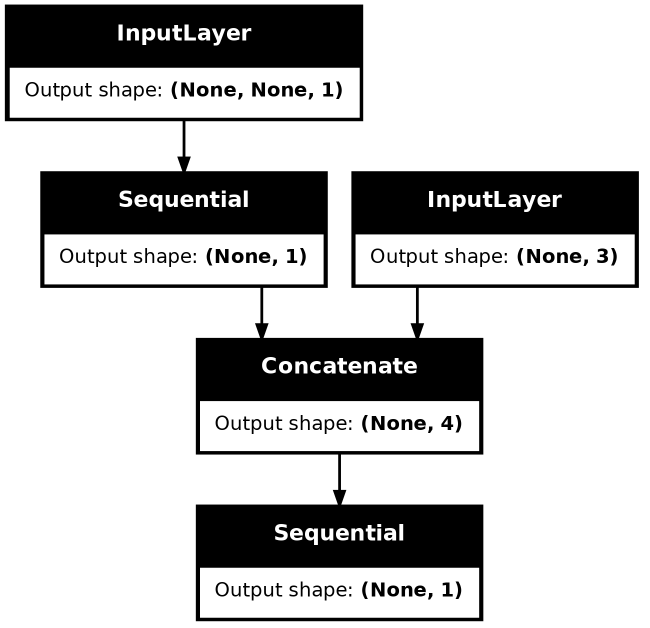

In [ ]:
#create input from counts
countsInputDim = 1
counts_input = tf.keras.Input(shape=(None,inputDim))

#create input from weather conditions
weatherInputDim = 3
weather_input = tf.keras.Input(shape=(weatherInputDim,))

In [ ]:
#create LSTM blocks
sequence_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(None, countsInputDim)),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(1, activation='sigmoid')],
                         name="sequence_analyzer")

#pass counts throught LSTM blocks
sequence_result = sequence_analyzer(counts_input)

In [ ]:
#merge counts and weather data
merged_input = tf.keras.layers.Concatenate()([sequence_result, weather_input])

#create a FCC block
merged_analyzer = tf.keras.Sequential(layers = [tf.keras.layers.InputLayer(shape=(merged_input.shape[-1],)),
                                                 #tf.keras.layers.Normalization(),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                                 tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
                                                 tf.keras.layers.Dense(1, activation='sigmoid')],
                                                 name="merged_analyzer")

In [ ]:
#pass merged data through dense layers
output = merged_analyzer(merged_input)

tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
#contruct a full model
model = tf.keras.Model(inputs=(counts_input, weather_input), outputs=output, name="TrafficPrediction")
model.summary()

#Run model on trainig dataset to check if it works
model.predict(train_dataset);

**Proszę:**

* przeprowadzić trening modelu z danymi meteorologicznymi
* narysować rysunki kontrolne
* porównać jakość wyniku z poprzednim modelem

In [ ]:
#BEGIN_SOLUTION
model = trainModel(model, train_dataset, val_dataset)
plotPrediction(model, df_merged, [train_street, val_street], scale, window_size=window_size)
#END_SOLUTION
pass

# Zadanie domowe

**Proszę:**

* wygenerować prognozę liczby rowerzystów na ulicy `Bulwary` dla całego roku 2023
* narysować panel z trzema rysunkami: 
    * liczba zliczeń rzeczywista i prognozowana
    * iloraz `rzeczywista/prognozowana`
    * histogram `(rzeczywista-prognozowana)/rzeczywista` z przedziałami zadanymi przez `bins=np.linspace(-2,2,50)`


In [ ]:
test_street = "Bulwary"
df = df[df["Data"]<"2024-01-01"]
df_filtered = df[df["Data"]<"2023-01-01"]

test_dataset = tf.data.Dataset.from_tensor_slices(slidingWindowWithWidth(df_filtered[test_street].values/scale))
test_dataset = test_dataset.map(lambda x: tf.reshape(x, (window_size, 1))).map(lambda y: (y[:-1,:], y[-1,:])).batch(16).cache()

y = df[test_street][window_size-1:]
y_pred = model.predict(test_dataset)[:,0]*scale

for iDay in range(0, 150):
    input = y_pred[-window_size+1:].reshape(1,window_size-1,1)/scale
    prediction = model.predict(input, verbose=0)[0,0]*scale
    prediction += tf.random.normal([1], mean=0, stddev=np.sqrt(prediction))
    y_pred = np.append(y_pred, model.predict(input, verbose=0)[0,0]*scale)

plt.plot(y_pred[-250:], 'go')

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(17,6))
import datetime
import matplotlib.dates as mdates
#BEGIN_SOLUTION
date = df["Data"][window_size-1:]
y = df[test_street][window_size-1:]
##
axes[1].set_title(test_street)
axes[0].plot(date, y, 'o', label="true");
axes[0].plot(date, y_pred, 'go', label="model");
#plot vertical line
axes[0].plot([datetime.date(2023, 1, 1), datetime.date(2023, 1, 1)], [0, y_pred.max()], 'r')
axes[0].legend()
axes[0].set_xlim([datetime.date(2021, 12, 1), datetime.date(2024, 1, 31)])
axes[0].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 12)))
axes[0].xaxis.set_minor_locator(mdates.MonthLocator())

##
axes[1].plot(date, y/y_pred, 'o', label="true/model");
axes[1].plot([date.min(), date.max()], [1,1], 'r')
axes[1].legend()
axes[1].set_ylim([-2,3])
axes[1].xaxis.set_major_locator(mdates.YearLocator(2, 1))
##
axes[2].hist((y-y_pred)/y, label=r"$\frac{true-model}{true}$", bins=np.linspace(-2,2,50));
axes[2].legend()
##
plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.15, hspace=0.4)
#END_SOLUTION
pass